In [11]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Reviews.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "snap/amazon-fine-food-reviews",
  file_path,

)

print("First 5 records:", df.head())

/tmp/ipython-input-11-3673965953.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:    Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality

In [1]:
!pip install azure-ai-textanalytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.6/298.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 7.1 MB/s eta 0:00:00


In [5]:
from azure.core.credentials import AzureKeyCredential

In [2]:
from google.colab import userdata

In [7]:
from azure.ai.textanalytics import TextAnalyticsClient

credential = AzureKeyCredential(userdata.get('CREDENTIAL'))

client = TextAnalyticsClient(endpoint=userdata.get('AZURE_ENDPOINT'), credential=credential)

In [96]:
texts = list(df['Text'])

In [112]:
import concurrent.futures

def analyze_sentiment_batch(client, texts_batch):
  """Analyzes sentiment for a batch of texts."""
  try:
    result = client.analyze_sentiment(texts_batch)
    return result
  except Exception as e:
    print(f"Error analyzing sentiment for a batch: {e}")
    return None

batch_size = 10
results = []
with concurrent.futures.ThreadPoolExecutor() as executor:
  futures = []
  for i in range(0, 1000, batch_size):
    texts_batch = texts[i:i + batch_size]
    futures.append(executor.submit(analyze_sentiment_batch, client, texts_batch))

  for future in concurrent.futures.as_completed(futures):
    batch_result = future.result()
    if batch_result:
      results.extend(batch_result)

print(f"Analyzed sentiment for {len(results)} texts.")

Analyzed sentiment for 1000 texts.


In [128]:
error_count = 0
for doc in results:
    if doc.is_error:
        print(doc)
        error_count += 1
print(f"Errors: {error_count}")

{'id': '9', 'error': TextAnalyticsError(code=InvalidDocument, message=A document within the request was too large to be processed. Document contains 5276 text elements. Limit document size to: 5120 text elements. For additional details on the data limitations see https://aka.ms/text-analytics-data-limits, target=None), 'is_error': True, 'kind': 'DocumentError'}
Errors: 1


In [132]:
# Limpar erros

for dic in results:
  if dic.is_error:
    results.remove(dic)

In [133]:
sentiment_results = []
for (i,doc) in enumerate(results):
    sentiment_results.append(
        {
        "text": texts[i],
        "sentiment": doc.sentiment,
        "scores":(
        doc.confidence_scores.positive,
        doc.confidence_scores.neutral,
        doc.confidence_scores.negative,
        )})

In [134]:
from collections import Counter

sentiment_counts = Counter([result['sentiment'] for result in sentiment_results])
sentiment_counts

Counter({'positive': 465, 'negative': 101, 'mixed': 426, 'neutral': 7})

In [135]:
import pandas as pd

sentiment_df = pd.DataFrame(sentiment_results)
sentiment_df.to_csv('sentiment_results.csv', index=False)

print("Sentiment results saved to sentiment_results.csv")
!ls

Sentiment results saved to sentiment_results.csv
sample_data  sentiment_results.csv


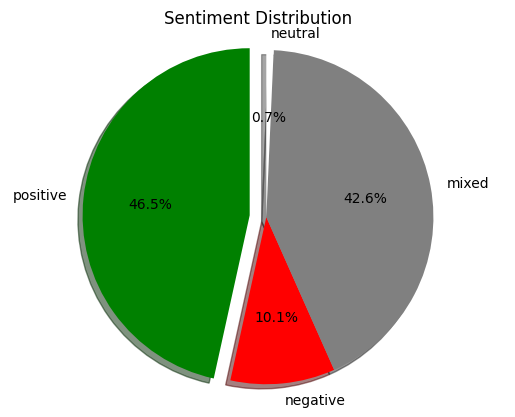

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
labels = list(sentiment_counts.keys())
sizes = list(sentiment_counts.values())
colors = ['green' if label == 'positive' else 'red' if label == 'negative' else 'white' if label == 'neutral' else 'gray' for label in labels]
explode = (0.1, 0, 0, 0)  # explode the first slice (positive)

# Plotting the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Sentiment Distribution')
plt.show()
